# Clustering

## Setup

In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../..')
import umap

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm

import bin.params as p
import bin.utils as u

sns.set_theme()

In [102]:
# july2024
FASTA_ALIGNED_CLEANED_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleanedJuly2024'
METADATA_DIR_PATH = f'{p.DATA_DIR}/csv/metadataJuly2024' 
FASTA_ALIGNED_CLEANED_DL_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleaned_dlJuly2024'
FASTA_ALIGNED_CLEANED_FIN_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleaned_finJuly2024'
SASA_ALIGNED_FIN_DIR_PATH = u.PATHS_BASED_ON_DATASET['test_new_234']['SASA_ALIGNED_FIN_DIR_PATH']

# old
FASTA_ALIGNED_CLEANED_DIR_PATH = f'{p.DATA_DIR}/csv/fasta_aligned_cleaned'
METADATA_DIR_PATH = f'{p.DATA_DIR}/csv/metadata'
FASTA_ALIGNED_CLEANED_DL_DIR_PATH = u.PATHS_BASED_ON_DATASET['classic']['FASTA_ALIGNED_CLEANED_DL_DIR_PATH']
FASTA_ALIGNED_CLEANED_FIN_DIR_PATH = u.PATHS_BASED_ON_DATASET['classic']['FASTA_ALIGNED_CLEANED_FIN_DIR_PATH']
SASA_ALIGNED_FIN_DIR_PATH = u.PATHS_BASED_ON_DATASET['classic']['SASA_ALIGNED_FIN_DIR_PATH']

# common
SIMILARITY_MATRICES_DIR_PATH = f'{p.DATA_DIR}/csv/similarity_matrices'
CLUSTERED_SPLITS_DIR_PATH = f'{p.DATA_DIR}/csv/clustered_splits'
TRAINVAL_VS_TESTNEW_H_SIMMATRIX_PATH = f'{SIMILARITY_MATRICES_DIR_PATH}/simmat_trainval_vs_testnew_h.csv'
TRAINVAL_VS_TESTNEW_L_SIMMATRIX_PATH = f'{SIMILARITY_MATRICES_DIR_PATH}/simmat_trainval_vs_testnew_l.csv'
TRAINVAL_VS_TEST_H_SIMMATRIX_PATH = f'{SIMILARITY_MATRICES_DIR_PATH}/simmat_trainval_vs_test_h.csv'
TRAINVAL_VS_TEST_L_SIMMATRIX_PATH = f'{SIMILARITY_MATRICES_DIR_PATH}/simmat_trainval_vs_test_l.csv'
DL_GUARD_DIR_PATH = f'{p.DATA_DIR}/csv/dl_guard'
DL_SEQS_OVER_DL_LIMIT_TEST_L = f'{DL_GUARD_DIR_PATH}/dl_test_l.csv'
DL_SEQS_OVER_DL_LIMIT_TEST_H = f'{DL_GUARD_DIR_PATH}/dl_test_h.csv'
DL_SEQS_OVER_DL_LIMIT_TESTNEW_L = f'{DL_GUARD_DIR_PATH}/dl_test_new_234_l.csv'
DL_SEQS_OVER_DL_LIMIT_TESTNEW_H = f'{DL_GUARD_DIR_PATH}/dl_test_new_234_h.csv'
SIMILARITY_DISTS_TEST_VS_TESTNEW_PLOT_H_PNG_PATH = f'{p.DATA_DIR}/png/sim_distros_test_vs_testnew_H.png'

# -----------

(FASTA_ALIGNED_CLEANED_DIR_PATH, SIMILARITY_MATRICES_DIR_PATH, CLUSTERED_SPLITS_DIR_PATH,
TRAINVAL_VS_TESTNEW_H_SIMMATRIX_PATH, TRAINVAL_VS_TESTNEW_L_SIMMATRIX_PATH,
TRAINVAL_VS_TEST_H_SIMMATRIX_PATH, TRAINVAL_VS_TEST_L_SIMMATRIX_PATH, METADATA_DIR_PATH,
DL_SEQS_OVER_DL_LIMIT_TEST_L, DL_SEQS_OVER_DL_LIMIT_TEST_H, DL_SEQS_OVER_DL_LIMIT_TESTNEW_L, DL_SEQS_OVER_DL_LIMIT_TESTNEW_H, 
DL_GUARD_DIR_PATH, FASTA_ALIGNED_CLEANED_DL_DIR_PATH, FASTA_ALIGNED_CLEANED_FIN_DIR_PATH, SASA_ALIGNED_FIN_DIR_PATH,
SIMILARITY_DISTS_TEST_VS_TESTNEW_PLOT_H_PNG_PATH
)

('../../data/csv/fasta_aligned_cleaned',
 '../../data/csv/similarity_matrices',
 '../../data/csv/clustered_splits',
 '../../data/csv/similarity_matrices/simmat_trainval_vs_testnew_h.csv',
 '../../data/csv/similarity_matrices/simmat_trainval_vs_testnew_l.csv',
 '../../data/csv/similarity_matrices/simmat_trainval_vs_test_h.csv',
 '../../data/csv/similarity_matrices/simmat_trainval_vs_test_l.csv',
 '../../data/csv/metadata',
 '../../data/csv/dl_guard/dl_test_l.csv',
 '../../data/csv/dl_guard/dl_test_h.csv',
 '../../data/csv/dl_guard/dl_test_new_234_l.csv',
 '../../data/csv/dl_guard/dl_test_new_234_h.csv',
 '../../data/csv/dl_guard',
 '../../data/csv/fasta_aligned_cleaned',
 '../../data/csv/fasta_aligned_cleaned',
 '../../data/csv/sasa_aligned',
 '../../data/png/sim_distros_test_vs_testnew_H.png')

**Create the required directories:**

In [3]:
command = f'mkdir -p {SIMILARITY_MATRICES_DIR_PATH} {CLUSTERED_SPLITS_DIR_PATH} {DL_GUARD_DIR_PATH} {FASTA_ALIGNED_CLEANED_DL_DIR_PATH} {FASTA_ALIGNED_CLEANED_FIN_DIR_PATH} {SASA_ALIGNED_FIN_DIR_PATH}'
! $command

**Load the FASTA datasets:**

In [4]:
fasta_path_base = f'{FASTA_ALIGNED_CLEANED_DIR_PATH}/fasta_{p.FINAL_NUMBERING_SCHEME}'
fasta_L_df = pd.read_csv(f'{fasta_path_base}_L.csv')
fasta_H_df = pd.read_csv(f'{fasta_path_base}_H.csv')
print('fasta_path_base', fasta_path_base)
print('fasta_L_df.shape', fasta_L_df.shape, 'fasta_H_df.shape', fasta_H_df.shape)

fasta_path_base ../../data/csv/fasta_aligned_cleaned/fasta_aho
fasta_L_df.shape (3286, 154) fasta_H_df.shape (3286, 165)


In [5]:
fasta_L_df.head(n=1)

,Id,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,12E8:L,D,I,V,M,T,Q,S,Q,K,...,G,A,G,T,K,L,E,L,K,R


In [6]:
fasta_H_df.head(n=1)

,Id,1,2,3,4,5,6,7,8,9,...,141,142,143,143A,144,145,146,147,148,149
0,12E8:H,E,V,Q,L,Q,Q,S,-,G,...,Q,G,T,-,L,V,T,V,S,A


**Define similarity-matrix related functions:**

In [32]:
def get_position_columns(df: pd.DataFrame):
    columns = [col for col in df.columns if col[0].isnumeric()]
    return columns

def identity_task(task):
    seq, seqs = task
    return seqs.apply(all_position_identity, seq2=seq, axis=1).astype(np.float16)

def all_position_identity(seq1, seq2):
    return (seq1 == seq2).mean()

def anarci_similarity_matrix(anarci_df: pd.DataFrame) -> pd.DataFrame:
    pos_columns = get_position_columns(anarci_df)
    positions = anarci_df[pos_columns]
    tasks = [(row, positions) for i, row in positions.iterrows()]
    rows = tqdm(map(identity_task, tasks), total=len(tasks), position=0, leave=True)
    matrix = pd.DataFrame(rows)
    matrix.columns = [int(col) for col in matrix.columns]
    matrix.index = matrix.columns
    return matrix

def anarci_similarity_for_matrices(matrix1_df: pd.DataFrame, matrix2_df: pd.DataFrame = None):
    if matrix2_df is None:
        matrix2_df = matrix1_df
    assert matrix1_df.columns.equals(matrix2_df.columns), 'Columns of matrices must match for the similarity calculations'
    # pull out only position columns - those that start with a digit
    pos_columns = [col for col in matrix1_df.columns if col[0].isnumeric()] 
    # pull out data only for the position columns
    positions_data1, positions_data2 = matrix1_df[pos_columns], matrix2_df[pos_columns]
    # compute similarity
    tasks = [(row, positions_data1) for i, row in positions_data2.iterrows()]
    rows = tqdm(map(identity_task, tasks), total=len(tasks), position=0, leave=True)
    # create the df and set the axes
    sim_matrix = pd.DataFrame(rows)
    sim_matrix.columns = matrix1_df['Id']
    sim_matrix.index = matrix2_df['Id']
    return sim_matrix

def harmonize_numbering_positions(fasta_H_new_df, fasta_H_classic_df, fasta_L_new_df, fasta_L_classic_df, col_diffs):
    print('before column add', fasta_H_new_df.shape, fasta_H_classic_df.shape, fasta_L_new_df.shape, fasta_L_classic_df.shape)
    fasta_H_new_df[col_diffs['H_yes_old_no_new']] = 'x'
    fasta_H_classic_df[col_diffs['H_no_old_yes_new']] = 'x'
    fasta_L_new_df[col_diffs['L_yes_old_no_new']] = 'x'
    fasta_L_classic_df[col_diffs['L_no_old_yes_new']] = 'x'
    assert set(fasta_H_new_df.columns) == set(fasta_H_classic_df.columns), 'column sets do not match'
    assert set(fasta_L_new_df.columns) == set(fasta_L_classic_df.columns), 'column sets do not match'
    fasta_H_new_df = fasta_H_new_df.reindex(columns=fasta_H_classic_df.columns)
    fasta_L_new_df = fasta_L_new_df.reindex(columns=fasta_L_classic_df.columns)
    print('after column add', fasta_H_new_df.shape, fasta_H_classic_df.shape, fasta_L_new_df.shape, fasta_L_classic_df.shape)
    return fasta_H_new_df, fasta_H_classic_df, fasta_L_new_df, fasta_L_classic_df

def process_dl(dataset_key, L_DL_seqs, H_DL_seqs):
    # -----------------------------------
    # remove from fasta
    FASTA_ALIGNED_CLEANED_DIR_PATH = u.PATHS_BASED_ON_DATASET[dataset_key]['FASTA_ALIGNED_CLEANED_DIR_PATH']
    FASTA_ALIGNED_CLEANED_DL_DIR_PATH = u.PATHS_BASED_ON_DATASET[dataset_key]['FASTA_ALIGNED_CLEANED_DL_DIR_PATH']
    fasta_base_path = f'{FASTA_ALIGNED_CLEANED_DIR_PATH}/fasta_{p.FINAL_NUMBERING_SCHEME}'
    fasta_dl_base_path = f'{FASTA_ALIGNED_CLEANED_DL_DIR_PATH}/fasta_{p.FINAL_NUMBERING_SCHEME}'
    print('cleaned dir path:', FASTA_ALIGNED_CLEANED_DIR_PATH)
    print('cleaned DL dir path:', FASTA_ALIGNED_CLEANED_DL_DIR_PATH)
    print('fasta_base_path:', fasta_base_path)
    print('fasta_dl_base_path:', fasta_dl_base_path)
    
    fasta_L_df = pd.read_csv(f'{fasta_base_path}_L.csv', index_col=0)
    fasta_H_df = pd.read_csv(f'{fasta_base_path}_H.csv', index_col=0)
    print('FASTA before DL drop, L shape:', fasta_L_df.shape, 'H shape', fasta_H_df.shape)
    
    fasta_L_df = fasta_L_df.drop(index=L_DL_seqs.index, errors='ignore')
    fasta_H_df = fasta_H_df.drop(index=H_DL_seqs.index, errors='ignore')
    print('FASTA after DL drop, L shape:', fasta_L_df.shape, 'H shape:', fasta_H_df.shape)
    
    fasta_L_df.to_csv(f'{fasta_dl_base_path}_L.csv')
    fasta_H_df.to_csv(f'{fasta_dl_base_path}_H.csv')
    
    # -----------------------------------
    # remove from sasa
    SASA_ALIGNED_DIR_PATH = u.PATHS_BASED_ON_DATASET[dataset_key]['SASA_ALIGNED_DIR_PATH']
    SASA_ALIGNED_DL_DIR_PATH = u.PATHS_BASED_ON_DATASET[dataset_key]['SASA_ALIGNED_DL_DIR_PATH']
    command = f"mkdir -p {SASA_ALIGNED_DIR_PATH} {SASA_ALIGNED_DL_DIR_PATH}"
    os.system(command)
    print('sasa aligned dir:', SASA_ALIGNED_DIR_PATH)
    print('sasa aligned dl dir:', SASA_ALIGNED_DL_DIR_PATH)

    sasa_L_df = pd.read_csv(f'{SASA_ALIGNED_DIR_PATH}/sasa_L.csv', index_col=0)
    sasa_H_df = pd.read_csv(f'{SASA_ALIGNED_DIR_PATH}/sasa_H.csv', index_col=0)
    print('SASA before DL drops | L shape:', sasa_L_df.shape, 'H shape:', sasa_H_df.shape)
    
    sasa_L_df = sasa_L_df.drop(index=L_DL_seqs.index, errors='ignore')
    sasa_H_df = sasa_H_df.drop(index=H_DL_seqs.index, errors='ignore')
    print('SASA after DL drops | L shape:', sasa_L_df.shape, 'H shape:', sasa_H_df.shape, '\n')
    
    sasa_L_df.to_csv(f'{SASA_ALIGNED_DL_DIR_PATH}/sasa_L.csv')
    sasa_H_df.to_csv(f'{SASA_ALIGNED_DL_DIR_PATH}/sasa_H.csv')

**Define clustering related functions:**

In [33]:
def fit_umap(df, n_components=2, random_state=0, **kwargs):
    reducer = umap.UMAP(n_components=n_components, 
                        random_state=random_state, 
                        metric='precomputed', 
                        **kwargs)
    embedding = reducer.fit_transform(df)
    return reducer, pd.DataFrame(embedding, 
                                 columns=[f'UMAP-{i+1}' for i in range(n_components)], 
                                 index=df.index)

def agglomerative_clustering(distance, linkage='complete', **kwargs):
    clusters = AgglomerativeClustering(
        linkage=linkage, 
        affinity='precomputed', 
        **kwargs).fit(distance).labels_
    return pd.Series(clusters+1, distance.index)

def do_clustering(similarity_mat, n_clusters, dist_thresh, umap_coords, 
                    linkage='single'):
    reducer, umap_coords = fit_umap(1-similarity_mat, n_neighbors=10)
    clusters = agglomerative_clustering(
        1-similarity_mat, 
        n_clusters=n_clusters,  
        distance_threshold=dist_thresh, 
        linkage=linkage
    )
    return clusters

In [34]:
X, Y = u.load_dataset('test_new_234', chains='H')
X

load_dataset: test_new_234, metadata file path: ../../data/csv/metadataJuly2024/metadata_H.csv, chains: H, shape: (888, 19)
load_dataset: test_new_234, X file path: ../../data/csv/fasta_aligned_cleaned_dlJuly2024/fasta_aho_H.csv, chains: H, shape: (888, 165)
load_dataset: test_new_234, Y file path: ../../data/csv/sasa_aligned_dlJuly2024/sasa_H.csv, chains: H, shape: (888, 165)


,Id,1,2,3,4,5,6,7,8,9,...,141,142,143,143A,144,145,146,147,148,149
0,7DF1:H,-,V,Q,L,V,Q,S,-,G,...,Q,G,T,-,M,V,T,V,S,-
1,7E9O:H,Q,V,Q,L,L,E,S,-,G,...,Q,G,T,-,T,V,T,V,S,S
2,7FGJ:H,-,V,Q,L,Q,Q,S,-,G,...,Q,G,T,-,S,V,T,V,S,S
3,7FGK:H,Q,V,Q,L,Q,Q,S,-,G,...,Q,G,T,-,S,V,T,V,S,S
4,7FGL:H,Q,V,Q,L,Q,Q,S,-,G,...,Q,G,T,-,S,V,T,V,S,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,8Y6A:H,Q,V,Q,L,V,Q,S,-,G,...,Q,G,T,-,L,V,T,V,S,S
884,8Y6H:H,E,V,Q,L,Q,E,S,-,G,...,Q,G,T,-,T,V,T,V,S,S
885,8Y6I:H,E,V,Q,L,Q,E,S,-,G,...,Q,G,T,-,T,V,T,V,S,S
886,8YX1:H,-,L,Q,L,Q,E,S,-,G,...,Q,G,T,-,L,V,T,V,S,S


---

## Trainval vs. Test (new)

In [9]:
# identify data leakage between the old data and the new
X_trainval_H_df, Y_trainval_H_df = u.load_dataset(['train', 'val'], chains='H')
X_trainval_L_df, Y_trainval_L_df = u.load_dataset(['train', 'val'], chains='L')
X_test_H_df, Y_test_H_df = u.load_dataset('test', chains='H')
X_test_L_df, Y_test_L_df = u.load_dataset('test', chains='L')
X_test_new_234_H_df, Y_test_new_234_H_df = u.load_dataset('test_new_234', chains='H')
X_test_new_234_L_df, Y_test_new_234_L_df = u.load_dataset('test_new_234', chains='L')
print('X_trainval_H_df.shape', X_trainval_H_df.shape, '\n', 
      'X_trainval_L_df.shape', X_trainval_L_df.shape, '\n', 
      'X_test_H_df.shape', X_test_H_df.shape, '\n', 
      'X_test_L_df.shape', X_test_L_df.shape, '\n', 
      'X_test_new_234_H_df.shape', X_test_new_234_H_df.shape, '\n', 
      'X_test_new_234_L_df.shape', X_test_new_234_L_df.shape)

load_dataset: ['train', 'val'], metadata file path: ../../data/csv/metadata/metadata_H.csv, chains: H, shape: (2643, 19)
load_dataset: ['train', 'val'], X file path: ../../data/csv/fasta_aligned_cleaned/fasta_aho_H.csv, chains: H, shape: (2643, 165)
load_dataset: ['train', 'val'], Y file path: ../../data/csv/sasa_aligned/sasa_H.csv, chains: H, shape: (2643, 165)
load_dataset: ['train', 'val'], metadata file path: ../../data/csv/metadata/metadata_L.csv, chains: L, shape: (2643, 19)
load_dataset: ['train', 'val'], X file path: ../../data/csv/fasta_aligned_cleaned/fasta_aho_L.csv, chains: L, shape: (2643, 154)
load_dataset: ['train', 'val'], Y file path: ../../data/csv/sasa_aligned/sasa_L.csv, chains: L, shape: (2643, 154)
load_dataset: test, metadata file path: ../../data/csv/metadata/metadata_H.csv, chains: H, shape: (643, 19)
load_dataset: test, X file path: ../../data/csv/fasta_aligned_cleaned/fasta_aho_H.csv, chains: H, shape: (643, 165)
load_dataset: test, Y file path: ../../data/cs

In [46]:
trainval_testnew234_coldiff = u.show_unique_columns(X_test_new_234_H_df, X_trainval_H_df, X_test_new_234_L_df, X_trainval_L_df)
trainval_testnew234_coldiff

{'H_yes_old_no_new': ['123A', '123B', '123C', '85H', '63B', '123D', '143A'],
 'H_no_old_yes_new': ['36A', '36D', '36E', '36C', '36B'],
 'L_yes_old_no_new': ['85A', '85B', '46A'],
 'L_no_old_yes_new': []}

In [25]:
X_test_new_234_H_df.head()

,Id,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,7DF1:H,-,V,Q,L,V,Q,S,-,G,...,G,Q,G,T,M,V,T,V,S,-
1,7E9O:H,Q,V,Q,L,L,E,S,-,G,...,G,Q,G,T,T,V,T,V,S,S
2,7FGJ:H,-,V,Q,L,Q,Q,S,-,G,...,G,Q,G,T,S,V,T,V,S,S
3,7FGK:H,Q,V,Q,L,Q,Q,S,-,G,...,G,Q,G,T,S,V,T,V,S,S
4,7FGL:H,Q,V,Q,L,Q,Q,S,-,G,...,G,Q,G,T,S,V,T,V,S,S


In [26]:
X_trainval_H_df, X_test_new_234_H_df, X_trainval_L_df, X_test_new_234_L_df = harmonize_numbering_positions(
    X_trainval_H_df, X_test_new_234_H_df, X_trainval_L_df, X_test_new_234_L_df, trainval_testnew234_coldiff)
X_trainval_H_df.shape, X_test_new_234_H_df.shape, X_trainval_L_df.shape, X_test_new_234_L_df.shape

before column add (2643, 165) (888, 163) (2643, 154) (721, 151)
after column add (2643, 170) (888, 170) (2643, 154) (721, 154)


((2643, 170), (888, 170), (2643, 154), (721, 154))

In [ ]:
H_sim_matrix = anarci_similarity_for_matrices(X_trainval_H_df, X_test_new_234_H_df).round(2)
H_sim_matrix.to_csv(TRAINVAL_VS_TESTNEW_H_SIMMATRIX_PATH)

In [35]:
H_sim_matrix = pd.read_csv(TRAINVAL_VS_TESTNEW_H_SIMMATRIX_PATH, index_col=0)
H_sim_matrix

,12E8:H,15C8:H,1A0Q:H,1A14:H,1A2Y:H,1A3L:H,1A3R:H,1A4J:H,1A4K:H,1A5F:H,...,6VC9:H,6YAX:H,6YXL:H,6YXM:H,6ZJG:H,7FAB:H,7LKI:H,7MLY:H,7SOE:H,8FAB:H
Id,,,,,,,,,,,,,,,,,,,,,
7DF1:H,0.62,0.60,0.62,0.65,0.49,0.60,0.60,0.57,0.57,0.60,...,0.50,0.58,0.64,0.57,0.45,0.51,0.29,0.60,0.45,0.58
7E9O:H,0.49,0.52,0.50,0.52,0.53,0.48,0.51,0.53,0.53,0.54,...,0.50,0.70,0.47,0.48,0.49,0.53,0.31,0.47,0.48,0.64
7FGJ:H,0.66,0.66,0.73,0.71,0.55,0.73,0.66,0.57,0.57,0.67,...,0.54,0.56,0.58,0.52,0.50,0.53,0.36,0.69,0.41,0.55
7FGK:H,0.66,0.66,0.72,0.72,0.56,0.73,0.66,0.58,0.58,0.67,...,0.54,0.56,0.59,0.53,0.49,0.53,0.36,0.69,0.41,0.55
7FGL:H,0.66,0.66,0.72,0.72,0.56,0.73,0.66,0.58,0.58,0.67,...,0.54,0.56,0.59,0.53,0.49,0.53,0.36,0.69,0.41,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8Y6A:H,0.59,0.58,0.58,0.61,0.49,0.56,0.56,0.57,0.57,0.56,...,0.48,0.55,0.66,0.59,0.43,0.50,0.29,0.55,0.45,0.55
8Y6H:H,0.62,0.64,0.69,0.67,0.56,0.66,0.63,0.59,0.59,0.63,...,0.53,0.57,0.54,0.54,0.47,0.51,0.34,0.64,0.46,0.56
8Y6I:H,0.62,0.64,0.69,0.67,0.56,0.66,0.63,0.59,0.59,0.63,...,0.53,0.57,0.54,0.54,0.47,0.51,0.34,0.64,0.46,0.56


In [36]:
H_maximums = H_sim_matrix.max(axis=1)
print('maximum allowed similarity', p.DL_MAXIMUM_ALLOWED_SIMILARITY)
H_DL_seqs = H_maximums[ H_maximums > p.DL_MAXIMUM_ALLOWED_SIMILARITY]
print(H_DL_seqs)
print('maximum observed sequence similarity', H_maximums.max())
H_DL_seqs.to_csv(DL_SEQS_OVER_DL_LIMIT_TESTNEW_H)

maximum allowed similarity 0.95
Series([], dtype: float64)
maximum observed sequence similarity 0.93


In [ ]:
L_sim_matrix = anarci_similarity_for_matrices(X_trainval_L_df, X_test_new_234_L_df).round(2)
L_sim_matrix.to_csv(TRAINVAL_VS_TESTNEW_L_SIMMATRIX_PATH)

In [9]:
L_sim_matrix = pd.read_csv(TRAINVAL_VS_TESTNEW_L_SIMMATRIX_PATH, index_col=0)
L_sim_matrix

,12E8:L,15C8:L,1A0Q:L,1A14:L,1A2Y:L,1A3L:L,1A3R:L,1A4J:L,1A4K:L,1A5F:L,...,6VC9:L,6YAX:L,6YXL:L,6YXM:L,6ZJG:L,7FAB:L,7LKI:L,7MLY:L,7SOE:L,8FAB:L
Id,,,,,,,,,,,,,,,,,,,,,
7DF1:L,0.69,0.67,0.63,0.64,0.66,0.67,0.79,0.71,0.71,0.79,...,0.74,0.55,0.74,0.50,0.52,0.54,0.67,0.71,0.58,0.57
7E9O:L,0.36,0.39,0.38,0.35,0.41,0.41,0.41,0.40,0.41,0.41,...,0.39,0.33,0.39,0.29,0.33,0.35,0.41,0.37,0.34,0.33
7FGJ:L,0.49,0.52,0.52,0.49,0.49,0.46,0.46,0.46,0.46,0.46,...,0.50,0.54,0.51,0.48,0.52,0.50,0.43,0.48,0.51,0.53
7FGK:L,0.49,0.52,0.52,0.49,0.49,0.46,0.46,0.46,0.46,0.46,...,0.50,0.54,0.51,0.48,0.52,0.50,0.43,0.48,0.51,0.53
7FGL:L,0.49,0.52,0.52,0.49,0.49,0.46,0.46,0.46,0.46,0.46,...,0.50,0.54,0.51,0.48,0.52,0.50,0.43,0.48,0.51,0.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8Y6A:L,0.71,0.71,0.67,0.65,0.67,0.65,0.66,0.68,0.68,0.66,...,0.80,0.59,0.86,0.54,0.56,0.58,0.63,0.69,0.59,0.60
8Y6H:L,0.37,0.39,0.41,0.37,0.41,0.41,0.39,0.44,0.44,0.39,...,0.39,0.33,0.38,0.32,0.33,0.36,0.41,0.37,0.36,0.35
8Y6I:L,0.37,0.39,0.39,0.37,0.40,0.40,0.39,0.43,0.44,0.39,...,0.39,0.33,0.37,0.31,0.33,0.35,0.40,0.37,0.34,0.34


In [26]:
assert L_sim_matrix.shape == H_sim_matrix.shape

In [10]:
L_maximums = L_sim_matrix.max(axis=1)
print('maximum allowed similarity', p.DL_MAXIMUM_ALLOWED_SIMILARITY)
L_DL_seqs = L_maximums[ L_maximums > p.DL_MAXIMUM_ALLOWED_SIMILARITY]
print(L_DL_seqs)
print('maximum observed sequence similarity', L_DL_seqs.max())
L_DL_seqs.to_csv(DL_SEQS_OVER_DL_LIMIT_TESTNEW_L)

maximum allowed similarity 0.95
Id
7DF1:L    0.96
7FGJ:L    0.97
7FGK:L    0.97
7FGL:L    0.97
7FGR:L    0.97
          ... 
8VUC:L    0.97
8VUI:L    0.97
8VVM:L    0.97
8W9H:L    0.96
8Y6I:L    0.97
Length: 167, dtype: float64
maximum observed sequence similarity 0.98


There are 167 light chains and 0 heavy chains that cause data leakage (>95% similarity with the training set).

In [11]:
# TODO: bacha na leaking L, mame v tom trochu bordel. Je tam >0.95 ale je to zaokruhlene na 2 desatinne miesta cize aj 0.9540 bude stale OK (nie >0.95)

### Remove the leaking sequences

In [ ]:
# refactoring similarity code to utils, we will need it further

In [14]:
FASTA_ALIGNED_CLEANED_DIR_PATH = u.PATHS_BASED_ON_DATASET['test_new_234']['FASTA_ALIGNED_CLEANED_DIR_PATH']
FASTA_ALIGNED_CLEANED_DL_DIR_PATH = u.PATHS_BASED_ON_DATASET['test_new_234']['FASTA_ALIGNED_CLEANED_DL_DIR_PATH']
print('cleaned dir path:', FASTA_ALIGNED_CLEANED_DIR_PATH)
print('cleaned DL dir path:', FASTA_ALIGNED_CLEANED_DL_DIR_PATH)

cleaned dir path: ../../data/csv/fasta_aligned_cleanedJuly2024
cleaned DL dir path: ../../data/csv/fasta_aligned_cleaned_dlJuly2024


In [15]:
fasta_base_path = f'{FASTA_ALIGNED_CLEANED_DIR_PATH}/fasta_{p.FINAL_NUMBERING_SCHEME}'
fasta_dl_base_path = f'{FASTA_ALIGNED_CLEANED_DL_DIR_PATH}/fasta_{p.FINAL_NUMBERING_SCHEME}'
fasta_L_df = pd.read_csv(f'{fasta_base_path}_L.csv', index_col=0)
fasta_H_df = pd.read_csv(f'{fasta_base_path}_H.csv', index_col=0)
print('FASTA before DL drop, L shape:', fasta_L_df.shape, 'H shape', fasta_H_df.shape)
fasta_L_df = fasta_L_df.drop(index=L_DL_seqs.index)
fasta_H_df = fasta_H_df.drop(index=H_DL_seqs.index)
print('FASTA after DL drop, L shape:', fasta_L_df.shape, 'H shape:', fasta_H_df.shape)
fasta_L_df.to_csv(f'{fasta_dl_base_path}_L.csv')
fasta_H_df.to_csv(f'{fasta_dl_base_path}_H.csv')

FASTA before DL drop, L shape: (888, 150) H shape (888, 162)
FASTA after DL drop, L shape: (721, 150) H shape: (888, 162)


In [63]:
# remove also from sasa

In [16]:
SASA_ALIGNED_DIR_PATH = u.PATHS_BASED_ON_DATASET['test_new_234']['SASA_ALIGNED_DIR_PATH']
SASA_ALIGNED_DL_DIR_PATH = u.PATHS_BASED_ON_DATASET['test_new_234']['SASA_ALIGNED_DL_DIR_PATH']
command = f"mkdir -p {SASA_ALIGNED_DIR_PATH} {SASA_ALIGNED_DL_DIR_PATH}"
print('sasa aligned dir:', SASA_ALIGNED_DIR_PATH)
print('sasa aligned dl dir:', SASA_ALIGNED_DL_DIR_PATH)
! $command

sasa aligned dir: ../../data/csv/sasa_alignedJuly2024
sasa aligned dl dir: ../../data/csv/sasa_aligned_dlJuly2024


In [17]:
print(SASA_ALIGNED_DIR_PATH, SASA_ALIGNED_DL_DIR_PATH)
sasa_L_df = pd.read_csv(f'{SASA_ALIGNED_DIR_PATH}/sasa_L.csv', index_col=0)
sasa_H_df = pd.read_csv(f'{SASA_ALIGNED_DIR_PATH}/sasa_H.csv', index_col=0)
print('SASA before DL drops | L shape:', sasa_L_df.shape, 'H shape:', sasa_H_df.shape)
sasa_L_df = sasa_L_df.drop(index=L_DL_seqs.index)
sasa_H_df = sasa_H_df.drop(index=H_DL_seqs.index)
print('SASA after DL drops | L shape:', sasa_L_df.shape, 'H shape:', sasa_H_df.shape, '\n')
sasa_L_df.to_csv(f'{SASA_ALIGNED_DL_DIR_PATH}/sasa_L.csv')
sasa_H_df.to_csv(f'{SASA_ALIGNED_DL_DIR_PATH}/sasa_H.csv')

../../data/csv/sasa_alignedJuly2024 ../../data/csv/sasa_aligned_dlJuly2024
SASA before DL drops | L shape: (888, 150) H shape: (888, 162)
SASA after DL drops | L shape: (721, 150) H shape: (888, 162) 



In [18]:
def harmonize_for_testing(
    fasta_test_key='FASTA_ALIGNED_CLEANED_DL_DIR_PATH',
    sasa_test_key='SASA_ALIGNED_DL_DIR_PATH',
    fasta_save_test_key='FASTA_ALIGNED_CLEANED_DL_DIR_PATH',
    sasa_save_test_key='SASA_ALIGNED_DL_DIR_PATH'):
    # read CSVs
    fasta_trainval_H_df = pd.read_csv(f"{u.PATHS_BASED_ON_DATASET['classic']['FASTA_ALIGNED_CLEANED_DIR_PATH']}/fasta_{p.FINAL_NUMBERING_SCHEME}_H.csv", index_col=0)
    fasta_trainval_L_df = pd.read_csv(f"{u.PATHS_BASED_ON_DATASET['classic']['FASTA_ALIGNED_CLEANED_DIR_PATH']}/fasta_{p.FINAL_NUMBERING_SCHEME}_L.csv", index_col=0)
    fasta_test_new_234_H_df = pd.read_csv(f"{u.PATHS_BASED_ON_DATASET['test_new_234'][fasta_test_key]}/fasta_{p.FINAL_NUMBERING_SCHEME}_H.csv", index_col=0)
    fasta_test_new_234_L_df = pd.read_csv(f"{u.PATHS_BASED_ON_DATASET['test_new_234'][fasta_test_key]}/fasta_{p.FINAL_NUMBERING_SCHEME}_L.csv", index_col=0)
    sasa_test_new_234_H_df = pd.read_csv(f"{u.PATHS_BASED_ON_DATASET['test_new_234'][sasa_test_key]}/sasa_H.csv", index_col=0)
    sasa_test_new_234_L_df = pd.read_csv(f"{u.PATHS_BASED_ON_DATASET['test_new_234'][sasa_test_key]}/sasa_L.csv", index_col=0)
    
    # drop columns that are in TEST but not in TRAIN. Models would have no clue on how to predict those
    col_diffs = u.show_unique_columns(fasta_test_new_234_H_df, fasta_trainval_H_df, fasta_test_new_234_L_df, fasta_trainval_L_df)
    print(col_diffs)
    print('before drop', fasta_test_new_234_H_df.shape, sasa_test_new_234_H_df.shape, fasta_test_new_234_L_df.shape, sasa_test_new_234_L_df.shape)
    fasta_test_new_234_H_df = fasta_test_new_234_H_df.drop(columns=col_diffs['H_no_old_yes_new'])
    sasa_test_new_234_H_df = sasa_test_new_234_H_df.drop(columns=col_diffs['H_no_old_yes_new'])
    fasta_test_new_234_L_df = fasta_test_new_234_L_df.drop(columns=col_diffs['L_no_old_yes_new'])
    sasa_test_new_234_L_df = sasa_test_new_234_L_df.drop(columns=col_diffs['L_no_old_yes_new'])
    print('after drop', fasta_test_new_234_H_df.shape, sasa_test_new_234_H_df.shape, fasta_test_new_234_L_df.shape, sasa_test_new_234_L_df.shape)
    
    # add columns from TRAIN into TEST -> make them empty ('-') and put expected Y as zero. We will ignore those in prediction scoring
    fasta_test_new_234_H_df[col_diffs['H_yes_old_no_new']] = '-'
    fasta_test_new_234_H_df = fasta_test_new_234_H_df.reindex(columns=fasta_trainval_H_df.columns)
    fasta_test_new_234_L_df[col_diffs['L_yes_old_no_new']] = '-'
    fasta_test_new_234_L_df = fasta_test_new_234_L_df.reindex(columns=fasta_trainval_L_df.columns)
    sasa_test_new_234_H_df[col_diffs['H_yes_old_no_new']] = 0
    sasa_test_new_234_H_df = sasa_test_new_234_H_df.reindex(columns=fasta_trainval_H_df.columns) # fasta columns ok for sasa matrix
    sasa_test_new_234_L_df[col_diffs['L_yes_old_no_new']] = 0
    sasa_test_new_234_L_df = sasa_test_new_234_L_df.reindex(columns=fasta_trainval_L_df.columns) # fasta columns ok for sasa matrix
    print('after dummy-column-from-test add', fasta_test_new_234_H_df.shape, sasa_test_new_234_H_df.shape, fasta_test_new_234_L_df.shape, sasa_test_new_234_L_df.shape)

    fasta_dir = u.PATHS_BASED_ON_DATASET['test_new_234'][fasta_save_test_key]
    sasa_dir = u.PATHS_BASED_ON_DATASET['test_new_234'][sasa_save_test_key]
    print('saving new fastas to dir', fasta_dir)
    print('saving new sasa to dir', sasa_dir)
    # save to CSV
    fasta_test_new_234_H_df.to_csv(f"{fasta_dir}/fasta_{p.FINAL_NUMBERING_SCHEME}_H.csv")
    sasa_test_new_234_H_df.to_csv(f"{sasa_dir}/sasa_H.csv")
    fasta_test_new_234_L_df.to_csv(f"{fasta_dir}/fasta_{p.FINAL_NUMBERING_SCHEME}_L.csv")
    sasa_test_new_234_L_df.to_csv(f"{sasa_dir}/sasa_L.csv")

In [19]:
harmonize_for_testing()

{'H_yes_old_no_new': ['123B', '123D', '63B', '143A', '123C', '85H', '123A'], 'H_no_old_yes_new': ['36D', '36A', '36B', '36E', '36C'], 'L_yes_old_no_new': ['85B', '85A', '46A'], 'L_no_old_yes_new': []}
before drop (888, 162) (888, 162) (721, 150) (721, 150)
after drop (888, 157) (888, 157) (721, 150) (721, 150)
after dummy-column-from-test add (888, 164) (888, 164) (721, 153) (721, 153)
saving new fastas to dir ../../data/csv/fasta_aligned_cleaned_dlJuly2024
saving new sasa to dir ../../data/csv/sasa_aligned_dlJuly2024


In [12]:
# generating the data for immunebuilder. it needs also data-leaked sequences, as it cannot process incomplete HL pairs
# TODO remove IB data later
# TODO update README with this detail
harmonize_for_testing(
    fasta_test_key='FASTA_ALIGNED_CLEANED_DIR_PATH',
    sasa_test_key='SASA_ALIGNED_DIR_PATH',
    fasta_save_test_key='FASTA_ALIGNED_CLEANED_FIN_DIR_PATH',
    sasa_save_test_key='SASA_ALIGNED_FIN_DIR_PATH')

{'H_yes_old_no_new': ['123B', '63B', '85H', '123A', '143A', '123D', '123C'], 'H_no_old_yes_new': ['36A', '36B', '36E', '36C', '36D'], 'L_yes_old_no_new': ['46A', '85A', '85B'], 'L_no_old_yes_new': []}
before drop (888, 162) (888, 162) (888, 150) (888, 150)
after drop (888, 157) (888, 157) (888, 150) (888, 150)
after dummy-column-from-test add (888, 164) (888, 164) (888, 153) (888, 153)
saving new fastas to dir ../../data/csv/fasta_aligned_cleaned_finJuly2024
saving new sasa to dir ../../data/csv/sasa_aligned_finJuly2024


In [ ]:
# generating standard data
harmonize_for_testing()

----

In [53]:
fasta_test_new_234_H_df = pd.read_csv(f"{u.PATHS_BASED_ON_DATASET['test_new_234']['FASTA_ALIGNED_CLEANED_DL_DIR_PATH']}/fasta_{p.FINAL_NUMBERING_SCHEME}_H.csv", index_col=0)
assert '36A' not in fasta_test_new_234_H_df.columns

In [43]:
fasta_trainval_H_df['123A']

Id
12E8:H    -
15C8:H    -
1A0Q:H    -
1A14:H    -
1A2Y:H    -
         ..
7X08:H    -
7X9E:H    -
7Z0X:H    -
7Z0Y:H    -
8FAB:H    -
Name: 123A, Length: 3286, dtype: object

In [ ]:
# we do not have the same number of chains in L and H
# due to data leakage in L
# that does not matter for now

----

## Trainval vs. Test (older dataset)

In [10]:
# compute matrixes for trainval vs. test (our own original data)
X_trainval_H_df, Y_trainval_H_df = u.load_dataset(['train', 'val'], chains='H')
X_trainval_L_df, Y_trainval_L_df = u.load_dataset(['train', 'val'], chains='L')
X_test_H_df, Y_test_H_df = u.load_dataset('test', chains='H')
X_test_L_df, Y_test_L_df = u.load_dataset('test', chains='L')
trainval_test_coldiff = u.show_unique_columns(fasta_H_new_df=X_trainval_H_df, 
                                            fasta_H_classic_df=X_test_H_df,
                                            fasta_L_new_df=X_trainval_L_df, 
                                            fasta_L_classic_df=X_test_L_df)
print(trainval_test_coldiff)
X_trainval_H_df, X_test_H_df, X_trainval_L_df, X_test_L_df = harmonize_numbering_positions(
    fasta_H_new_df=X_trainval_H_df, 
    fasta_H_classic_df=X_test_H_df, 
    fasta_L_new_df=X_trainval_L_df, 
    fasta_L_classic_df=X_test_L_df, 
    col_diffs=trainval_test_coldiff)
print(f'AFTER HARMONIZE COLUMNS - X_trainval_H: {X_trainval_H_df.shape}, X_test_H: {X_test_H_df.shape}, X_trainval_L: {X_trainval_L_df.shape}, X_test_L: {X_test_L_df.shape}')
H_sim_matrix = anarci_similarity_for_matrices(X_trainval_H_df, X_test_H_df).round(2)
H_sim_matrix.to_csv(TRAINVAL_VS_TEST_H_SIMMATRIX_PATH)
print('H chains processed for trainval vs. test')
L_sim_matrix = anarci_similarity_for_matrices(X_trainval_L_df, X_test_L_df).round(2)
L_sim_matrix.to_csv(TRAINVAL_VS_TEST_L_SIMMATRIX_PATH)
print('L chains processed for trainval vs. test')

load_dataset: ['train', 'val'], metadata file path: ../../data/csv/metadata/metadata_H.csv, chains: H, shape: (2643, 19)
load_dataset: ['train', 'val'], X file path: ../../data/csv/fasta_aligned_cleaned/fasta_aho_H.csv, chains: H, shape: (2643, 165)
load_dataset: ['train', 'val'], Y file path: ../../data/csv/sasa_aligned/sasa_H.csv, chains: H, shape: (2643, 165)
load_dataset: ['train', 'val'], metadata file path: ../../data/csv/metadata/metadata_L.csv, chains: L, shape: (2643, 19)
load_dataset: ['train', 'val'], X file path: ../../data/csv/fasta_aligned_cleaned/fasta_aho_L.csv, chains: L, shape: (2643, 154)
load_dataset: ['train', 'val'], Y file path: ../../data/csv/sasa_aligned/sasa_L.csv, chains: L, shape: (2643, 154)
load_dataset: test, metadata file path: ../../data/csv/metadata/metadata_H.csv, chains: H, shape: (643, 19)
load_dataset: test, X file path: ../../data/csv/fasta_aligned_cleaned/fasta_aho_H.csv, chains: H, shape: (643, 165)
load_dataset: test, Y file path: ../../data/cs

  0%|          | 0/643 [00:00<?, ?it/s]

H chains processed for trainval vs. test


  0%|          | 0/643 [00:00<?, ?it/s]

L chains processed for trainval vs. test


In [12]:
H_sim_matrix = pd.read_csv(TRAINVAL_VS_TEST_H_SIMMATRIX_PATH, index_col=0)
H_maximums = H_sim_matrix.max(axis=1)
H_exceeding = H_maximums[ H_maximums >= p.DL_MAXIMUM_ALLOWED_SIMILARITY ]
H_exceeding

Id
6M0Z:H    1.00
6M2R:H    1.00
6TUL:H    0.98
6VLN:H    1.00
6VRT:H    1.00
          ... 
7T0I:H    1.00
7T0J:H    1.00
7T0K:H    0.98
7TUY:H    1.00
7V5N:H    1.00
Length: 81, dtype: float64

In [106]:
# double-check that all of those come from the old test dataset
metadata_df = pd.read_csv(f'{METADATA_DIR_PATH}/metadata_all.csv', index_col=0)
metadata_df.loc[list(H_exceeding.index)]['year']

6M0Z:H    2021
6M2R:H    2021
6TUL:H    2020
6VLN:H    2020
6VRT:H    2020
          ... 
7T0I:H    2022
7T0J:H    2022
7T0K:H    2022
7TUY:H    2022
7V5N:H    2022
Name: year, Length: 80, dtype: int64

In [13]:
L_sim_matrix = pd.read_csv(TRAINVAL_VS_TEST_L_SIMMATRIX_PATH, index_col=0)
L_maximums = L_sim_matrix.max(axis=1)
L_exceeding = L_maximums[ L_maximums > p.DL_MAXIMUM_ALLOWED_SIMILARITY ]
L_exceeding

Id
6LRA:L    0.99
6LTG:L    0.97
6LUN:L    0.97
6LYN:L    0.97
6M0Z:L    1.00
          ... 
7V5N:L    1.00
7VSW:L    1.00
7VYT:L    0.97
7WLZ:L    0.96
7Z0X:L    0.96
Length: 238, dtype: float64

In [108]:
# length of this should match the length of L_exceeding and no error should be given
metadata_df.loc[list(L_exceeding.index)]['year']

6LRA:L    2020
6LTG:L    2020
6LUN:L    2020
6LYN:L    2021
6M0Z:L    2021
          ... 
7V5N:L    2022
7VSW:L    2021
7VYT:L    2022
7WLZ:L    2022
7Z0X:L    2022
Name: year, Length: 238, dtype: int64

In [24]:
process_dl('classic', L_exceeding, H_exceeding)

cleaned dir path: ../../data/csv/fasta_aligned_cleaned
cleaned DL dir path: ../../data/csv/fasta_aligned_cleaned
fasta_base_path: ../../data/csv/fasta_aligned_cleaned/fasta_aho
fasta_dl_base_path: ../../data/csv/fasta_aligned_cleaned/fasta_aho
FASTA before DL drop, L shape: (3048, 153) H shape (3205, 164)
FASTA after DL drop, L shape: (3048, 153) H shape: (3205, 164)
sasa aligned dir: ../../data/csv/sasa_aligned
sasa aligned dl dir: ../../data/csv/sasa_aligned
SASA before DL drops | L shape: (3048, 153) H shape: (3205, 164)
SASA after DL drops | L shape: (3048, 153) H shape: (3205, 164) 



In [26]:
x, y = u.load_dataset('test', chains='H')
xl, yl = u.load_dataset('test', chains='L')
xl

load_dataset: test, metadata file path: ../../data/csv/metadata/metadata_H.csv, chains: H, shape: (643, 19)
load_dataset: test, X file path: ../../data/csv/fasta_aligned_cleaned/fasta_aho_H.csv, chains: H, shape: (562, 165)
load_dataset: test, Y file path: ../../data/csv/sasa_aligned/sasa_H.csv, chains: H, shape: (562, 165)
load_dataset: test, metadata file path: ../../data/csv/metadata/metadata_L.csv, chains: L, shape: (643, 19)
load_dataset: test, X file path: ../../data/csv/fasta_aligned_cleaned/fasta_aho_L.csv, chains: L, shape: (405, 154)
load_dataset: test, Y file path: ../../data/csv/sasa_aligned/sasa_L.csv, chains: L, shape: (405, 154)


,Id,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,6LCS:L,D,I,E,L,T,Q,S,P,A,...,G,G,G,T,K,L,E,I,K,R
1,6LDV:L,A,Q,G,L,T,Q,T,P,S,...,G,G,G,T,E,V,V,V,K,G
2,6LDW:L,-,Q,V,L,T,Q,T,P,S,...,G,G,G,T,E,V,V,V,T,G
3,6LDX:L,D,P,V,M,T,Q,T,P,P,...,G,G,G,T,E,V,V,V,K,G
4,6LDY:L,A,L,V,L,T,Q,T,P,S,...,G,G,G,T,E,V,V,V,K,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,7WPV:L,-,-,V,V,T,Q,P,-,A,...,G,G,G,T,K,V,T,V,L,Q
401,7WRV:L,D,I,Q,M,T,Q,S,P,S,...,G,G,G,T,K,V,E,I,-,-
402,7X08:L,-,-,A,L,T,Q,P,-,P,...,G,G,G,T,K,L,T,V,L,G
403,7X9E:L,-,-,A,L,T,Q,P,-,L,...,G,G,G,T,K,L,T,V,L,G


We have 80 heavy chain test sequences that exhibit more than 95% similarity with thrainval.
And 238 light chain test sequences.

----

### Code dump

In [ ]:
# old code

In [117]:
# load the 4 fasta dataframes
FASTA_ALIGNED_CLEANED_DIR_PATH_CLASSIC = f'{p.DATA_DIR}/csv/fasta_aligned_cleaned' # old
FASTA_ALIGNED_CLEANED_DIR_PATH_NEWJULY2024 = f'{p.DATA_DIR}/csv/fasta_aligned_cleanedJuly2024' # july2024
fasta_path_base = f'{FASTA_ALIGNED_CLEANED_DIR_PATH}/fasta_{p.FINAL_NUMBERING_SCHEME}'
fasta_L_classic_df = pd.read_csv(f'{FASTA_ALIGNED_CLEANED_DIR_PATH_CLASSIC}/fasta_{p.FINAL_NUMBERING_SCHEME}_L.csv')
fasta_H_classic_df = pd.read_csv(f'{FASTA_ALIGNED_CLEANED_DIR_PATH_CLASSIC}/fasta_{p.FINAL_NUMBERING_SCHEME}_H.csv')
fasta_L_new_df = pd.read_csv(f'{FASTA_ALIGNED_CLEANED_DIR_PATH_NEWJULY2024}/fasta_{p.FINAL_NUMBERING_SCHEME}_L.csv')
fasta_H_new_df = pd.read_csv(f'{FASTA_ALIGNED_CLEANED_DIR_PATH_NEWJULY2024}/fasta_{p.FINAL_NUMBERING_SCHEME}_H.csv')
(fasta_L_classic_df.shape, fasta_H_classic_df.shape, fasta_L_new_df.shape, fasta_H_new_df.shape)

((3286, 154), (3286, 165), (888, 151), (888, 163))

In [118]:
# investigate

In [119]:
H_new_c, H_classic_c = set(get_position_columns(fasta_H_new_df)), set(get_position_columns(fasta_H_classic_df))

In [120]:
H_new_c.difference(H_classic_c)
# '36A', '36B', '36C', '36D', '36E'
# mame v datach 2022-2024 len 3 Heavy chainy ktore  obsahuju vsetky tieto pozicie. vsetky ostatne nemaju nic

{'36A', '36B', '36C', '36D', '36E'}

In [121]:
x = fasta_H_new_df[['36', '36A', '36B', '36C', '36D', '36E']].isin(['-']).sum(axis=1)
x[x==0]

620    0
621    0
622    0
dtype: int64

In [122]:
fasta_H_new_df[ fasta_H_new_df['36A'] != '-']

,Id,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
620,8GBV:H,Q,V,Q,L,K,Q,W,-,G,...,G,Q,G,T,P,V,S,V,S,S
621,8GBW:H,-,V,Q,L,K,Q,W,-,G,...,G,Q,G,I,P,V,S,V,S,S
622,8GBX:H,Q,V,Q,L,Q,Q,W,-,G,...,G,Q,G,T,T,V,I,V,S,S


In [123]:
diff_cols = list(H_classic_c.difference(H_new_c))
print(diff_cols)
x = fasta_H_classic_df[diff_cols].isin(['-']).sum(axis=1)
fasta_H_classic_df[diff_cols].isin(['-']).sum(axis=0)

['143A', '63B', '123C', '85H', '123A', '123B', '123D']


143A    3285
63B     3282
123C    3284
85H     3285
123A    3282
123B    3283
123D    3285
dtype: int64

In [124]:
L_new_c, L_classic_c = set(get_position_columns(fasta_L_new_df)), set(get_position_columns(fasta_L_classic_df))
diff_cols = list(L_classic_c.difference(L_new_c))
print(diff_cols)
x = fasta_L_classic_df[diff_cols].isin(['-']).sum(axis=0)
print(x)
fasta_L_classic_df.shape

['85B', '85A', '46A']
85B    3285
85A    3261
46A    3285
dtype: int64


(3286, 154)

In [125]:
diff_cols = list(L_new_c.difference(L_classic_c))
print(diff_cols)
x = fasta_L_new_df[diff_cols].isin(['-']).sum(axis=0)
print(x)
fasta_L_new_df.shape

[]
Series([], dtype: float64)


(888, 151)

----

### Comparing the similarity matrices and similarity max distributions

In [42]:
trainval_vs_test_simmat_H = pd.read_csv(TRAINVAL_VS_TEST_H_SIMMATRIX_PATH, index_col=0)
trainval_vs_testnew_simmat_H = pd.read_csv(TRAINVAL_VS_TESTNEW_H_SIMMATRIX_PATH, index_col=0)

/Users/rbeno/anaconda3/envs/mamba/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rbeno/anaconda3/envs/mamba/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


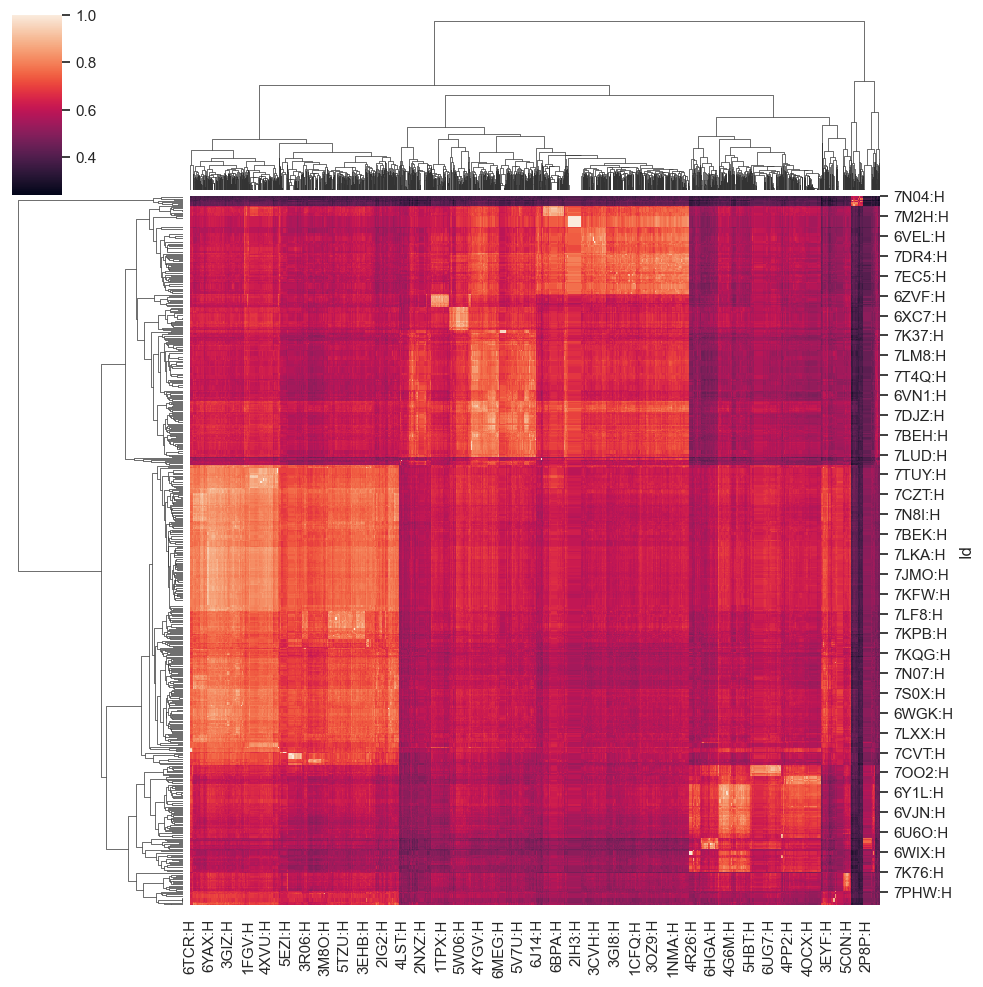

In [45]:
sns.clustermap(trainval_vs_test_simmat_H)

/Users/rbeno/anaconda3/envs/mamba/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rbeno/anaconda3/envs/mamba/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


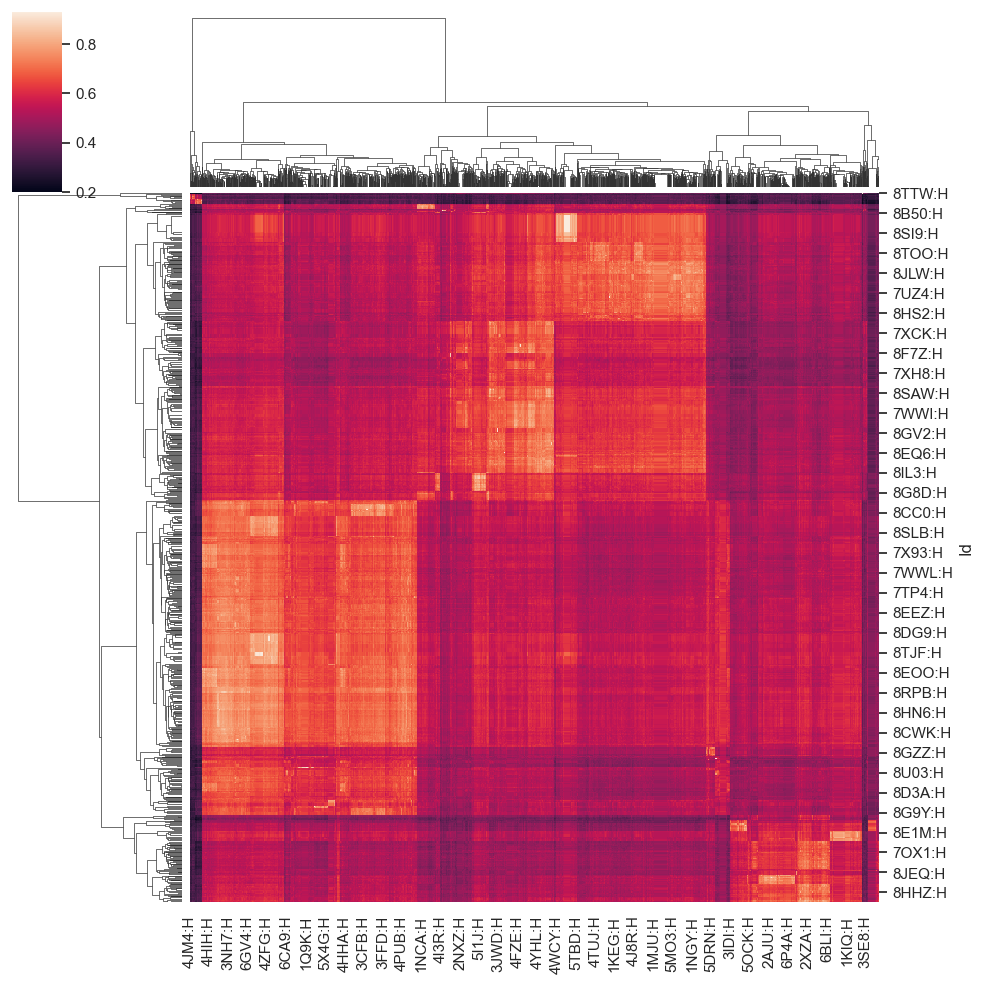

In [47]:
sns.clustermap(trainval_vs_testnew_simmat_H)

In [126]:
def show_sim_dists(type, title):
    if type == 'mean':
        max_test_sims_vs_trainval = trainval_vs_test_simmat_H.mean(axis=1)
        max_testnew_sims_vs_trainval = trainval_vs_testnew_simmat_H.mean(axis=1)
        #trainval_vs_testnew_simmat_H = pd.read_csv(TRAINVAL_VS_TESTNEW_H_SIMMATRIX_PATH, index_col=0)
    elif type == 'max':
        max_test_sims_vs_trainval = trainval_vs_test_simmat_H.max(axis=1)
        max_testnew_sims_vs_trainval = trainval_vs_testnew_simmat_H.max(axis=1)
    else:
        raise ValueError('invalid type')
        
    print(f'old test: {max_test_sims_vs_trainval.mean()}, new test: {max_testnew_sims_vs_trainval.mean()}')
    
    len_test, len_testnew = len(max_test_sims_vs_trainval), len(max_testnew_sims_vs_trainval)
    simdist_df = pd.DataFrame({
        title: pd.concat([max_test_sims_vs_trainval, max_testnew_sims_vs_trainval]).values,
        'Test set': [f'2020-2022\n({len_test} sequences)'] * len_test + [f'2022-2024\n({len_testnew} sequences)'] * len_testnew
    })
    mean1, mean2 = max_test_sims_vs_trainval.mean(), max_testnew_sims_vs_trainval.mean()
    median1, median2 = max_test_sims_vs_trainval.std(), max_testnew_sims_vs_trainval.std()
    var1, var2 = max_test_sims_vs_trainval.var(), max_testnew_sims_vs_trainval.var()
    
    # Display the first few rows of the data to verify
    size = 0.02
    v = sns.violinplot(data=simdist_df, x='Test set', y=title, hue='Test set', cut=0)
    plt.text(0, mean1 + size, f'mean: {mean1:.4f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
    plt.text(1, mean2 + size, f'mean: {mean2:.4f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
    plt.text(0, mean1 - 0.00, f'std: {median1:.4f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
    plt.text(1, mean2 - 0.00, f'std: {median2:.4f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
    plt.text(0, mean1 - size, f'var: {var1:.4f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
    plt.text(1, mean2 - size, f'var: {var2:.4f}', horizontalalignment='center', size='medium', color='white', weight='semibold')
    colors = ['blue', 'orange']
    plt.axhline(max_test_sims_vs_trainval.quantile(0.25), color=colors[0], linestyle='--', linewidth=1)
    plt.axhline(max_test_sims_vs_trainval.quantile(0.75), color=colors[0], linestyle='--', linewidth=1)
    plt.axhline(max_testnew_sims_vs_trainval.quantile(0.25), color=colors[1], linestyle='--', linewidth=1)
    plt.axhline(max_testnew_sims_vs_trainval.quantile(0.75), color=colors[1], linestyle='--', linewidth=1)
    
    y_ticks = np.linspace(simdist_df[title].min(), simdist_df[title].max(), 20)
    _=plt.yticks(y_ticks, [f'{tick:.2f}' for tick in y_ticks])
    plt.title(f'{title} per test set')
    plt.grid(True)


old test: 0.889751166407465, new test: 0.8132995495495496
old test: 0.6200771073447869, new test: 0.5589938193017033
saving to: ../../data/png/sim_distros_test_vs_testnew_H.png


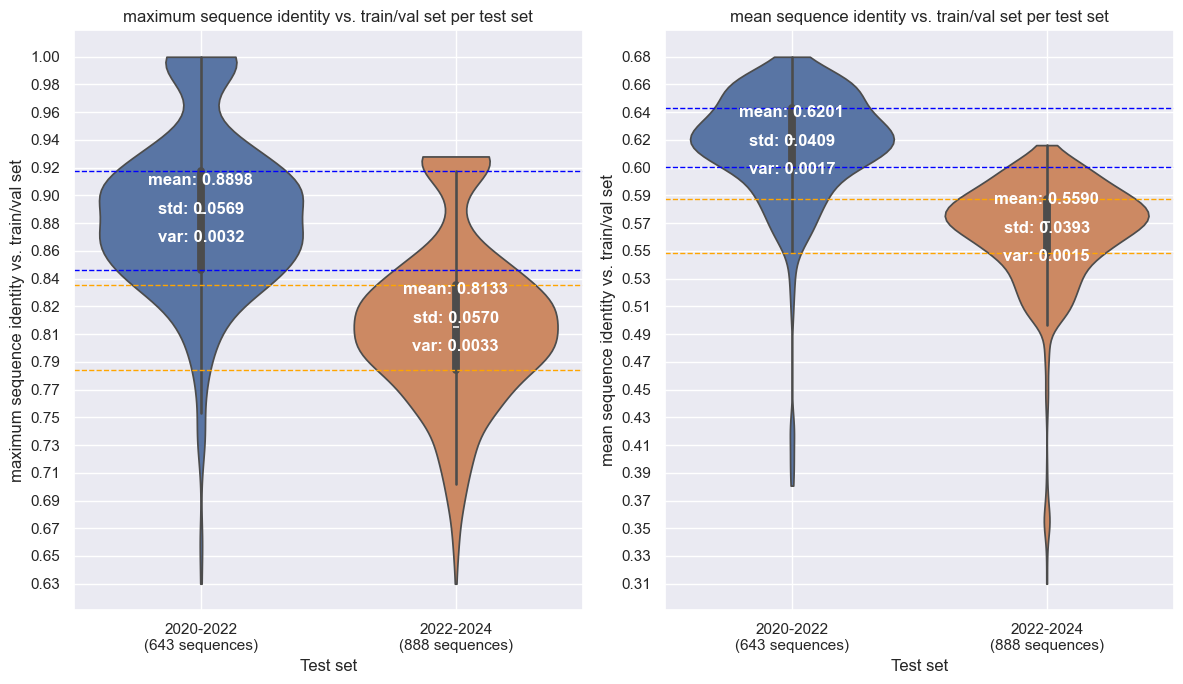

In [129]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
show_sim_dists('max', 'maximum sequence identity vs. train/val set')
plt.subplot(1, 2, 2)
show_sim_dists('mean', 'mean sequence identity vs. train/val set')

plt.tight_layout()
print('saving to:', SIMILARITY_DISTS_TEST_VS_TESTNEW_PLOT_H_PNG_PATH)
plt.savefig(SIMILARITY_DISTS_TEST_VS_TESTNEW_PLOT_H_PNG_PATH)
plt.show()

In [79]:
max_test_sims_vs_trainval.max()

1.0

In [71]:
from scipy.stats import ks_2samp
# Perform Kolmogorov-Smirnov test
ks_stat, p_value = ks_2samp(max_test_sims_vs_trainval, max_testnew_sims_vs_trainval)
# Display the results
ks_stat, p_value

(0.599414344359912, 2.7603701647958806e-125)

In [72]:
from scipy.spatial.distance import jensenshannon

# Compute Jensen-Shannon Divergence
js_divergence = jensenshannon(max_test_sims_vs_trainval, max_testnew_sims_vs_trainval, base=2)

js_divergence

ValueError: operands could not be broadcast together with shapes (643,) (888,) 

In [52]:
sns.violinplot(max_test_sims_vs_trainval, max_testnew_sims_vs_trainval)

TypeError: violinplot() takes from 0 to 1 positional arguments but 2 were given

In [ ]:
X_orig_L_df, _ = u.load_dataset(['train', 'val'], chains='L')
L_sim_matrix = anarci_similarity_for_matrices(X_orig_L_df, fasta_L_new_df).round(2)
L_sim_matrix

----

## Compute similarity matrices

**Compute L similarity matrix - this may take a while:**

In [8]:
similarity_L = anarci_similarity_matrix(fasta_L_df)
similarity_L.to_csv(f'{SIMILARITY_MATRICES_DIR_PATH}/sim_mat_L.csv')

NameError: name 'anarci_similarity_matrix' is not defined

In [9]:
similarity_L = pd.read_csv(f'{SIMILARITY_MATRICES_DIR_PATH}/sim_mat_L.csv', index_col=0)
similarity_L.columns = [int(col) for col in similarity_L.columns]
similarity_L.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285
0,1.0000,0.7256,0.654,0.660,0.6733,0.6274,0.7320,0.6860,0.6860,0.7320,...,0.7715,0.7715,0.6080,0.5750,0.7583,0.6010,0.5884,0.5884,0.6274,0.5947
1,0.7256,1.0000,0.706,0.706,0.7320,0.6665,0.6733,0.6665,0.6665,0.6733,...,0.7583,0.7583,0.6274,0.6143,0.7450,0.6143,0.6010,0.6274,0.6406,0.6010


**Compute H similarity matrix - this may take a while:**

In [33]:
similarity_H = anarci_similarity_matrix(fasta_H_df)
similarity_H.to_csv(f'{SIMILARITY_MATRICES_DIR_PATH}/sim_mat_H.csv')

  0%|          | 0/3286 [00:00<?, ?it/s]

In [14]:
similarity_H = pd.read_csv(f'{SIMILARITY_MATRICES_DIR_PATH}/sim_mat_H.csv', index_col=0)
similarity_H.columns = [int(col) for col in similarity_H.columns]
similarity_H.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285
0,1.000,0.823,0.7197,0.7134,0.5790,0.7010,0.8170,0.6035,0.6035,0.7744,...,0.671,0.671,0.5854,0.5180,0.6710,0.561,0.6157,0.567,0.6035,0.6157
1,0.823,1.000,0.7680,0.7440,0.6035,0.7197,0.8535,0.6035,0.6035,0.8290,...,0.671,0.671,0.5790,0.5366,0.6646,0.561,0.6035,0.579,0.5913,0.6157


**Create structure similarity matrix (by averaging L-sim-mat and H-sim-mat values):**

In [35]:
similarity = (similarity_L + similarity_H) / 2
similarity.to_csv(f'{SIMILARITY_MATRICES_DIR_PATH}/sim_mat_all.csv')

In [7]:
similarity = pd.read_csv(f'{SIMILARITY_MATRICES_DIR_PATH}/sim_mat_all.csv', index_col=0)
similarity.columns = [int(col) for col in similarity.columns]
similarity.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,3276,3277,3278,3279,3280,3281,3282,3283,3284,3285
0,1.0000,0.7743,0.68685,0.6867,0.62615,0.6642,0.7745,0.64475,0.64475,0.75320,...,0.72125,0.72125,0.5967,0.54650,0.71465,0.58100,0.60205,0.5777,0.61545,0.60520
1,0.7743,1.0000,0.73700,0.7250,0.66775,0.6931,0.7634,0.63500,0.63500,0.75115,...,0.71465,0.71465,0.6032,0.57545,0.70480,0.58765,0.60225,0.6032,0.61595,0.60835


In [9]:
similarity2 = similarity.copy()
labels = fasta_L_df['Id'].map(lambda x: x[:-2])
similarity2.index = similarity2.columns = labels
similarity2.head(n=1)

Id,12E8,15C8,1A0Q,1A14,1A2Y,1A3L,1A3R,1A4J,1A4K,1A5F,...,7WPE,7WPF,7WPH,7WPV,7WRV,7X08,7X9E,7Z0X,7Z0Y,8FAB
Id,,,,,,,,,,,,,,,,,,,,,
12E8,1.0,0.7743,0.68685,0.6867,0.62615,0.6642,0.7745,0.64475,0.64475,0.7532,...,0.72125,0.72125,0.5967,0.5465,0.71465,0.581,0.60205,0.5777,0.61545,0.6052


/Users/rbeno/anaconda3/envs/mamba/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rbeno/anaconda3/envs/mamba/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


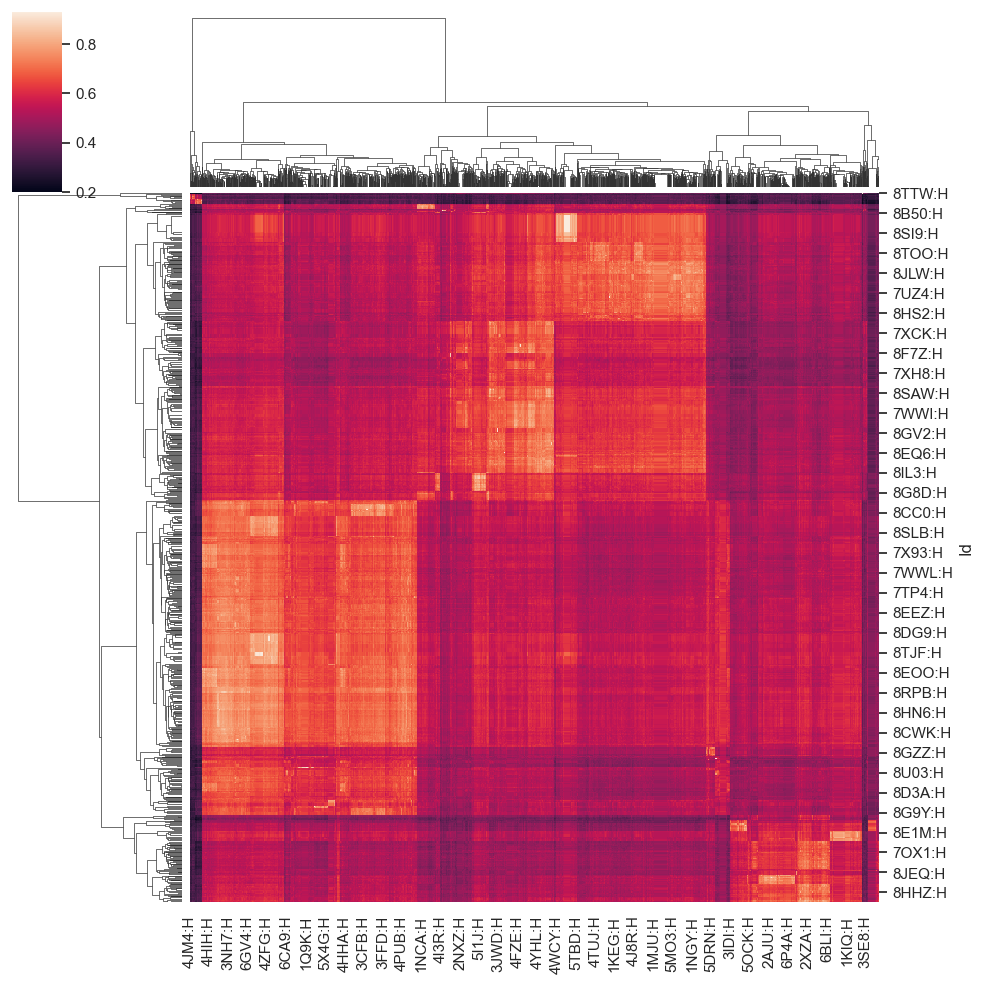

In [38]:
sns.clustermap(H_sim_matrix)

/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


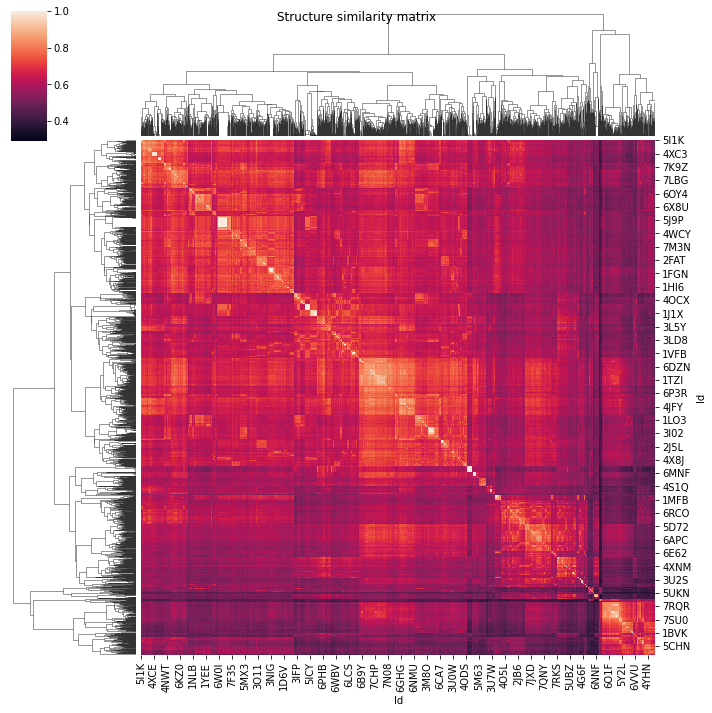

In [10]:
plot = sns.clustermap(similarity2)
plot.fig.suptitle('Structure similarity matrix')
plot.fig.savefig(f'{p.DATA_DIR}/png/similarity_matrix_all.png')

**Check if similarity matrices have some rows/columns full of NaN values:**

In [16]:
# remove columns and rows that are full of NaN
all_missing_rows = similarity[similarity.isna().all(axis=1)]
all_missing_columns = similarity[similarity.isna().all(axis=0)]
indices_to_delete = list(all_missing_rows.index.intersection(all_missing_columns.index))
print('indices to be deleted', list(indices_to_delete))

indices to be deleted []


**Delete them if you wish:**

In [61]:
#similarity.drop(index=indices_to_delete, columns=indices_to_delete, inplace=True)

---

## Cluster

In [17]:
identities = np.linspace(p.IDENTITY_START, p.IDENTITY_END, p.IDENTITY_STEPS_NUMBER)
identities

In [18]:
fasta_L_df.shape, fasta_H_df.shape

((3286, 154), (3286, 165))

In [19]:
sim_matrix_options = {
    'all': similarity, 
    'L': similarity_L,
    'H': similarity_H
}
sim_matrix_used = sim_matrix_options[p.CLUSTERING_CHAINS]
sim_matrix_used.head(n=2)

In [28]:
for identity in tqdm(identities):
    identity_percent, distance = int(identity * 100), 1 - identity
    print(f'generating sim{identity_percent}_{p.CLUSTERING_CHAINS}.csv')
    
    reducer, hl_umap = fit_umap(sim_matrix_used, p.CLUSTERING_N_NEIGHBORS)
    clusters = do_clustering(similarity, None, distance, umap_coords=hl_umap)
    clusters.name = 'cluster'
    
    if p.CLUSTERING_CHAINS == 'L':
        sequence_ids = fasta_L_df['Id']; sequence_ids.name = 'sequence_id'
    elif p.CLUSTERING_CHAINS == 'H':
        sequence_ids = fasta_H_df['Id']; sequence_ids.name = 'sequence_id'
    elif p.CLUSTERING_CHAINS == 'all':
        sequence_ids = pd.concat([fasta_L_df['Id'], fasta_H_df['Id']]).reset_index(drop=True)
        sequence_ids.name = 'sequence_id'
        clusters2 = clusters.copy(); clusters = pd.concat([clusters, clusters2]).reset_index(drop=True)
        
        
    df = pd.concat([sequence_ids, clusters.astype(int)], axis=1, join='inner').reset_index(drop=True)
    df.to_csv(f'{CLUSTERED_SPLITS_DIR_PATH}/sim{identity_percent}_{p.CLUSTERING_CHAINS}.csv')

  0%|          | 0/11 [00:00<?, ?it/s]

generating sim80_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


generating sim82_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


generating sim84_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


generating sim86_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


generating sim88_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


generating sim90_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


generating sim92_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


generating sim94_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


generating sim96_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


generating sim98_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


generating sim100_all.csv


/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/SFS/user/wp/benor/test/proto-moto/condaenv/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
